# Image Classification With TensorFlow - ML Training
The following example demonstrate how to build Keras and TensorFlow based image classifier<br>
starting with data exploration, training, validation and model generation<br>
the next notebook demonstrate how to automatically create an inference server based on nuclio (serverless functions) 

This demo is based on the following:<br>
* https://github.com/tensorflow/docs/tree/master/site/en/tutorials
* https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification/log

# Package installation

In [1]:
!pip install --upgrade git+https://github.com/fchollet/keras
!pip install --upgrade tensorflow 
!pip install --upgrade numpy

# Import Library

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os
import zipfile

# Define locations
BASE_PATH = os.getcwd()
DATA_PATH = BASE_PATH + "/cats_and_dogs_filtered/"
!mkdir model
MODEL_PATH = BASE_PATH + '/model/'

# Define image parameters
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


In [2]:
DATA_PATH + 'catsndogs.zip'

'/User/demos/image_classification/cats_and_dogs_filtered/catsndogs.zip'

# Download the data

In [3]:
!mkdir cats_and_dogs_filtered
# Download a sample stocks file from Iguazio demo bucket in S3
!curl -L "iguazio-sample-data.s3.amazonaws.com/catsndogs.zip" > ./cats_and_dogs_filtered/catsndogs.zip

mkdir: cannot create directory 'cats_and_dogs_filtered': File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.2M  100 65.2M    0     0  12.0M      0  0:00:05  0:00:05 --:--:-- 12.4M


In [4]:
zip_ref = zipfile.ZipFile(DATA_PATH + 'catsndogs.zip', 'r')
zip_ref.extractall('cats_and_dogs_filtered')
zip_ref.close()

# Prepare Traning Data

In [5]:
import json

In [6]:
def build_prediction_map(categories_map):
    return {v:k for k ,v in categories_map.items()}

In [7]:
# create filenames list (jpg only)
filenames = [file for file in os.listdir(DATA_PATH+"/cats_n_dogs") if file.endswith('jpg')]
categories = []

# categories & prediction classes map
categories_map = {
    'dog': 1,
    'cat': 0,
}
prediction_map = build_prediction_map(categories_map)
with open(MODEL_PATH + 'prediction_classes_map.json', 'w') as f:
    json.dump(prediction_map, f)

# Full samples DF
for filename in filenames:
    category = filename.split('.')[0]
    categories.append([categories_map[category]])

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df['category'] = df['category'].astype('str');

In [8]:
df.head()

,filename,category
0,cat.0.jpg,[0]
1,cat.1.jpg,[0]
2,cat.10.jpg,[0]
3,cat.100.jpg,[0]
4,cat.101.jpg,[0]


In [9]:
df.tail()

,filename,category
1995,dog.995.jpg,[1]
1996,dog.996.jpg,[1]
1997,dog.997.jpg,[1]
1998,dog.998.jpg,[1]
1999,dog.999.jpg,[1]


### See Total In count

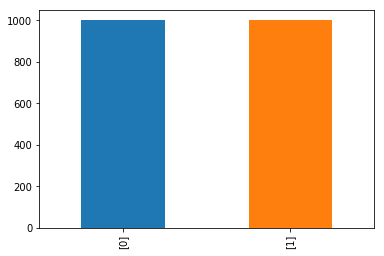

In [10]:
df['category'].value_counts().plot.bar()

From our data we have 12000 cats and 12000 dogs

# See sample image

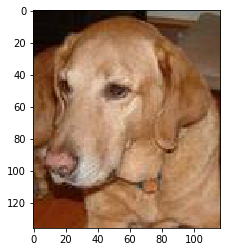

In [11]:
sample = random.choice(filenames)
image = load_img(DATA_PATH+"/cats_n_dogs/"+sample)
plt.imshow(image)

# Build Model

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________

# Callbacks

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

**Early Stop**

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [14]:
earlystop = EarlyStopping(patience=10)

**Learning Rate Reduction**

We will reduce the learning rate when then accuracy not increase for 2 steps

In [15]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
callbacks = [earlystop, learning_rate_reduction]

### Prepare Test and Train Data

In [17]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

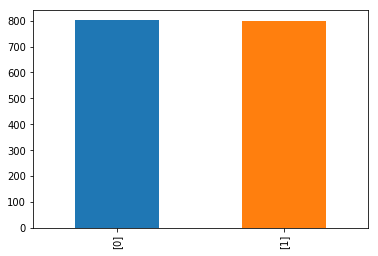

In [18]:
train_df['category'] = train_df['category'].astype('str');
train_df['category'].value_counts().plot.bar()

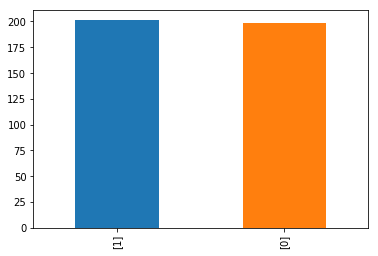

In [19]:
validate_df['category'].value_counts().plot.bar()

In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

# Traning Generator

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    DATA_PATH + "/cats_n_dogs/", 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'binary',
    batch_size = batch_size
)

Found 1600 images belonging to 2 classes.


### Validation Generator

In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    DATA_PATH + "/cats_n_dogs/", 
    x_col = 'filename',
    y_col = 'category',
    target_size = IMAGE_SIZE,
    class_mode = 'binary',
    batch_size = batch_size
)

Found 400 images belonging to 2 classes.


# See how our generator work

In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)

example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    DATA_PATH + "/cats_n_dogs/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 images belonging to 1 classes.


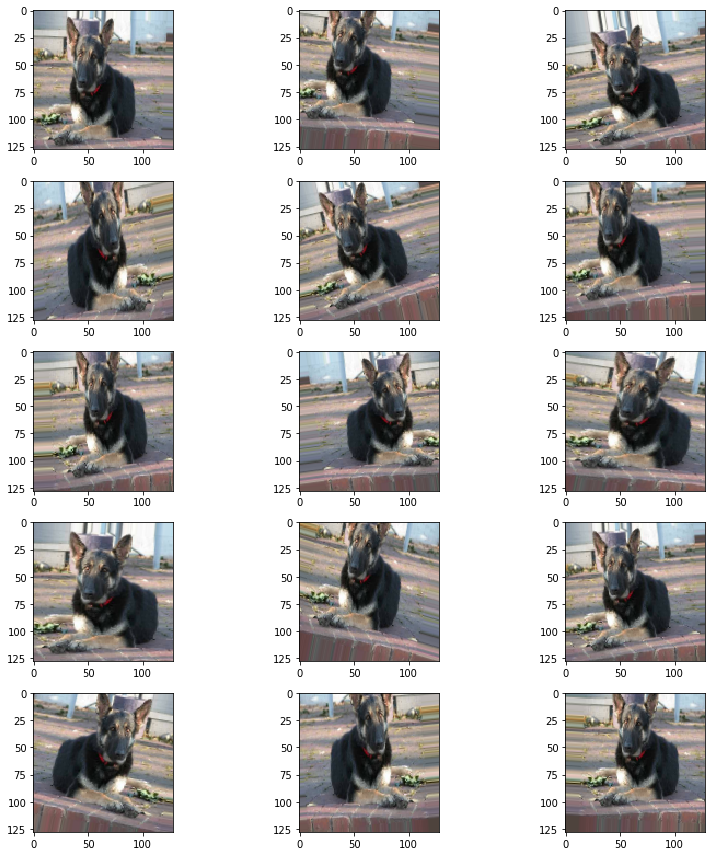

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Seem to be nice 

# Fit Model

In [25]:
FAST_RUN = True
epochs=6 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/6
106/106 [==============================] - 91s 860ms/step - loss: 1.0711 - acc: 0.5610 - val_loss: 1.6532 - val_acc: 0.5615
Epoch 2/6
106/106 [==============================] - 91s 861ms/step - loss: 0.8617 - acc: 0.5814 - val_loss: 1.7512 - val_acc: 0.5169
Epoch 3/6
106/106 [==============================] - 91s 859ms/step - loss: 0.7430 - acc: 0.6217 - val_loss: 0.7054 - val_acc: 0.6494
Epoch 4/6
106/106 [==============================] - 91s 862ms/step - loss: 0.7168 - acc: 0.6274 - val_loss: 0.7734 - val_acc: 0.5766
Epoch 5/6
106/106 [==============================] - 91s 863ms/step - loss: 0.6523 - acc: 0.6597 - val_loss: 0.9501 - val_acc: 0.5481

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/6
106/106 [==============================] - 91s 855ms/step - loss: 0.6135 - acc: 0.6789 - val_loss: 0.8093 - val_acc: 0.6208


# Save Model

In [26]:
model.save(MODEL_PATH + 'cats_dogs.hd5')

# Visualize Training

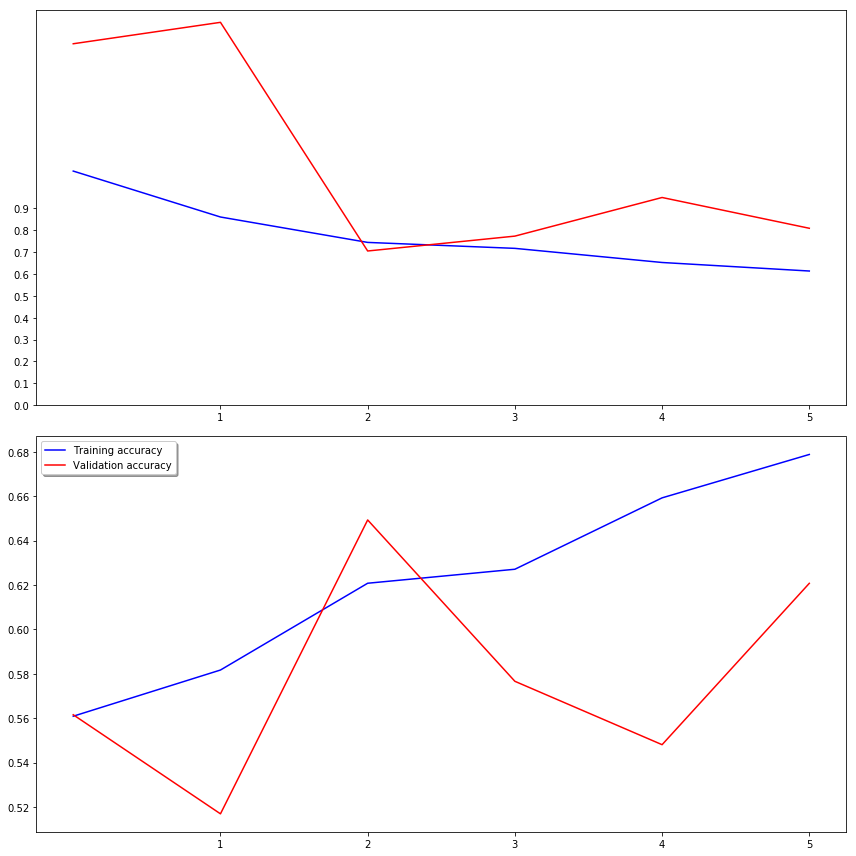

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# Prepare Testing Data

In [28]:
test_filenames = [file for file in os.listdir(DATA_PATH + "validation") if file.endswith('jpg')]
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(f'found {nb_samples} samples in:\t{DATA_PATH}validation/')

found 1000 samples in:	/User/demos/image_classification/cats_and_dogs_filtered/validation/


# Create Testing Generator

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    DATA_PATH + "/validation/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 1000 images.


# Predict

In [30]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
# print (predict)

As predicted of binary classification result return probability that image likely to be a dog. So we will have threshold 0.5 which mean if predicted value more than 50% it is a dog and under 50% will be a cat.

In [31]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

### Virtaulize Result

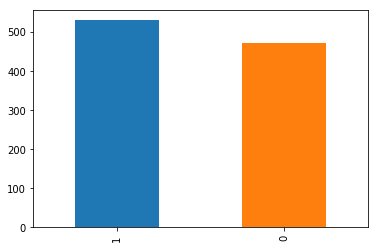

In [32]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

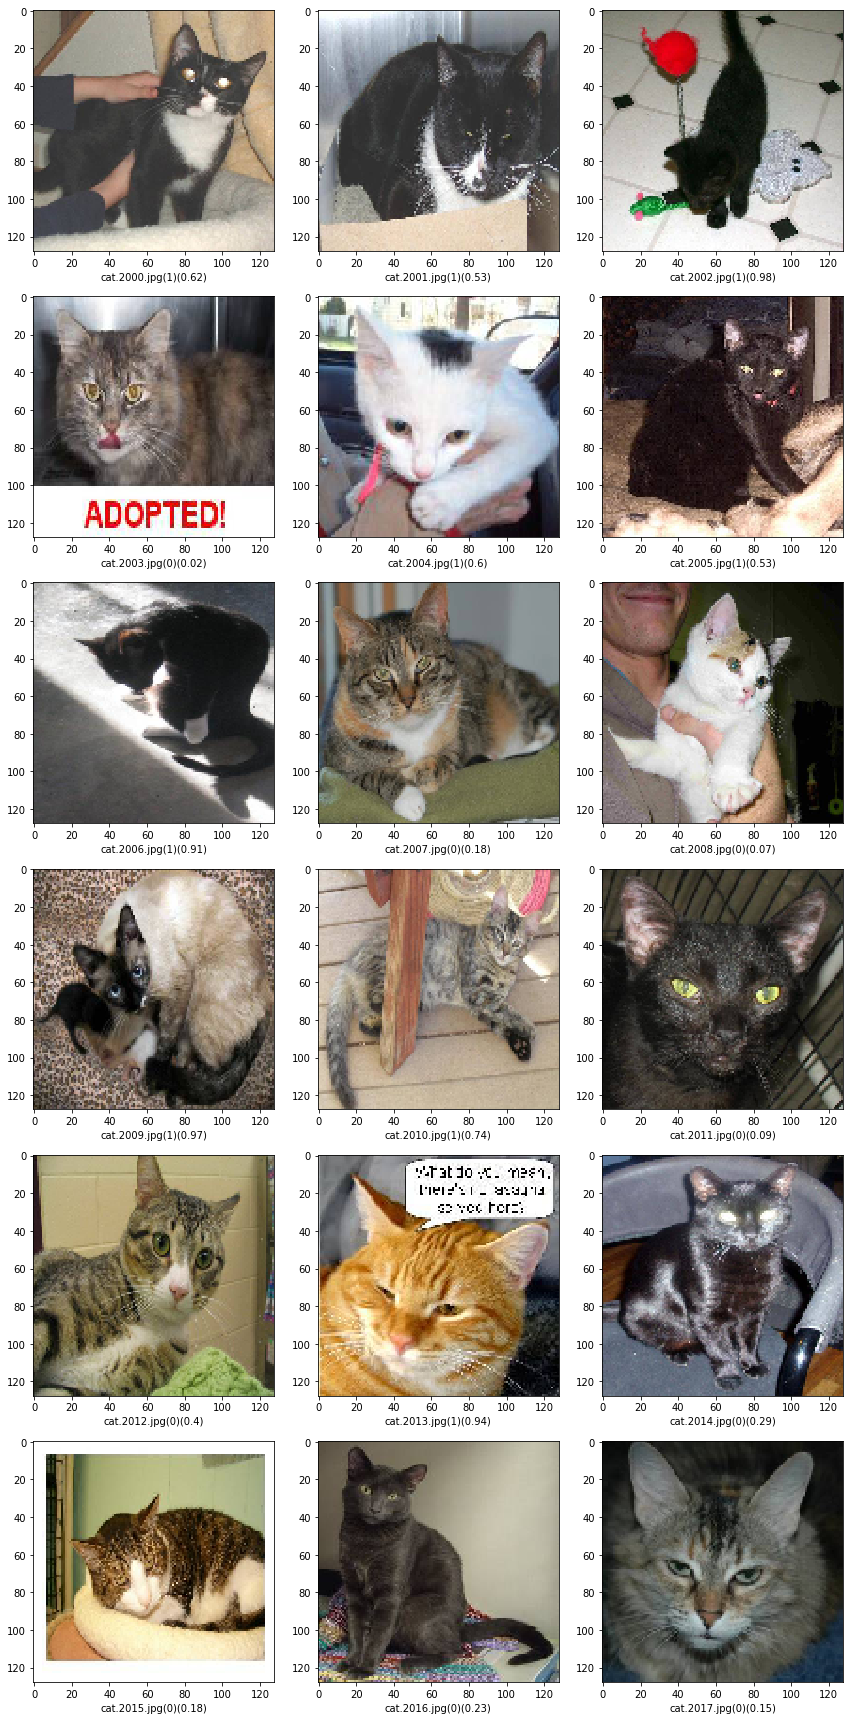

In [33]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img(DATA_PATH + "/validation/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()